## Version Control
- Hybrid model with alpha(weight) layer
- no extra Dense layer
- alpha within $[0,1]$

In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.stattools import pacf
from matplotlib.pyplot import figure
from statsmodels.tsa.arima.model import ARIMA
# !pip install scikit-learn==0.24
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_lattice as tfl
import matplotlib.ticker as ticker
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
df = pd.read_csv("WorldCases.csv", index_col = False)
df.reset_index(drop=True, inplace=True)
# countries we are interested in
countries = ["Japan", "Canada", "Brazil", "Argentina", "Singapore", "Italy", "The United Kingdom"]
df1 = df[countries]
df1.insert(0, "date", df["date"])
df = df1
df

,date,Japan,Canada,Brazil,Argentina,Singapore,Italy,The United Kingdom
0,2020-02-01,1,1,0,0,3,0,1
1,2020-02-02,2,0,0,0,2,0,0
2,2020-02-03,5,0,0,0,0,0,0
3,2020-02-04,0,4,0,0,0,0,1
4,2020-02-05,3,1,0,0,6,0,18
...,...,...,...,...,...,...,...,...
943,2022-09-01,167340,0,16806,0,2154,21814,5225
944,2022-09-02,153313,0,15842,0,2044,20498,4616
945,2022-09-03,135425,21303,14821,0,1948,19158,4350
946,2022-09-04,117130,0,11471,11636,1549,17660,3808


# Data Smoothing
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [4]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# for each country
df1 = df.copy()  # deep copy
df1 = df1.iloc[6:]
for country in countries:
    # holder
    temp = []
    # take average, starting from 7th day
    for i in range(6,len(df)):
        # remove day of week effect
        ave = np.mean(df[country].iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
        temp.append(ave)
    df1[country] = temp
df1.set_index("date", inplace=True)

In [5]:
# input: original dataset, country we want
# output: all data, sorted by date, of that country
def extract(dataset, country):
    # select data only from the input country
    temp = dataset.to_dict()[country]
    temp = pd.Series(temp)
    # reset index
    # temp.reset_index(drop=True, inplace=True)
    return temp

# Data Preprocessing
## Differencing
- Differencing of time series in discrete time
- transformation of series to a new time series wehre values are the difference between consecutive values of previous series
- help stablizing the mean of time series by removing trend

In [6]:
# create a differenced series, output as Series
# interval: order of differencing, default = 1
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        # no need to difference
        if (interval == 0):
            value = dataset[i]
        else:
            value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced value
# input: single original, single prediction, interval(default as 1)
def invert_difference(history, yhat, interval=1):
    if (interval == 0):
        return yhat
    else:
        return yhat + history

## Scaling
- Scale the data to [-1,1]

In [7]:
# scale train and test data to [-1, 1]
# input: train(np array, train_size*1), test(np array, test_size*1)
def scale(train, test):
    # find scalers
    aveTrain = np.mean(train)
    maxTrain = max(train)
    minTrain = min(train)
    scaler = [aveTrain, maxTrain, minTrain]
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = (train - aveTrain)/(maxTrain-minTrain)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = (test - aveTrain)/(maxTrain-minTrain)
    return scaler, train_scaled, test_scaled
# inverse scaling for a forecasted value
# input: scaler, single prediction yhat
def invert_scale(scaler, yhat):
    inverted = yhat*(scaler[1]-scaler[2]) + scaler[0]
    return inverted[0][0]  # output: a number

## Reshaping

In [8]:
# convert to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg  # output: a data frame
# prepare data for neural networks
def prepare_data(series, diff, train_size, test_size, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # differencing
    diff_series = difference(raw_values, diff)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # split into train & test
    train_diff, test_diff = diff_values[:(train_size-diff)], diff_values[(train_size-diff):]
    # rescaling
    scaler, train_scaled, test_scaled = scale(train_diff, test_diff)
    # adjust data type for train_scaled, test_scaled
    train_scaled = [row[0][0] for row in train_scaled]
    test_scaled = [row[0][0] for row in test_scaled]
    # convert to supervised
    train = series_to_supervised(train_scaled, n_lag, n_seq).values
    test = series_to_supervised(test_scaled, n_lag, n_seq).values
    return scaler, train, test  # scaler: list of np array, train: np array, test: np array

# Model Training

In [9]:
class alpha_layer(keras.layers.Layer):
    def __init__(self, input_dim=1, units=1):
        super(alpha_layer, self).__init__()
        # check with initializer.get_config()
        initializer = tf.keras.initializers.RandomUniform(minval = 0, maxval = 1)
        self.alpha = self.add_weight(shape=(input_dim, units), initializer=initializer, 
                                     constraint=lambda x: tf.clip_by_value(x, 0, 1), trainable=True)

    def call(self, input1, input2):
        return tf.matmul(input1, self.alpha) + tf.matmul(input2, (1-self.alpha))

In [10]:
def fit_comb(train, n_lag, n_seq, n_batch, n_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    Z = X.reshape(X.shape[0], 1, X.shape[1])
    # AR layer
    input1 = tf.keras.layers.Input(shape=(X.shape[1],))
    AR = tfl.layers.Linear(num_input_dims=X.shape[1], units=n_seq)(input1)
    
    # lstm layer
    input2 = tf.keras.layers.Input(shape=(Z.shape[1],Z.shape[2]))
    lstm = layers.LSTM(n_seq)(input2)
    # fully connected lstm
    lstm_connected = tf.keras.layers.Dense(n_seq)(lstm)
    
    # alpha layer
    layer = alpha_layer()
    #added = layer(AR, lstm)
    added = layer(AR, lstm_connected)
    model = tf.keras.models.Model(inputs=[input1,input2], outputs=added)
    # compile before training or testing
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(n_epoch):
        model.fit([X, Z], y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Make Forecasts

In [11]:
# make one forecast with a hybird model
def forecast_comb(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    Z = X.reshape(1, 1, len(X))
    X = X.reshape(1, len(X))
    # make forecast
    forecast = model.predict([X,Z], batch_size=n_batch)
    return [x for x in forecast[0, :]][0]
    return [x for x in forecast[0, :]][0]
# make forecasts in a row
def make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff):
    forecasts = []
    prev = raw_value[-(test_size+diff):(len(raw_value)-diff)]  # Y_(t-diff)
    for i in range(len(test)):
        X = test[i, 0:n_lag]
        # make forecast
        forecast = forecast_comb(model, X, n_batch)
        # invert scaling
        forecast = invert_scale(scaler, forecast)
        # invert differencing
        forecast = invert_difference(prev[i], forecast)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

## Evaluation with RMSE, MAE, MAPE

In [12]:
# evaluate the model for each step in forcasting
def evaluate_forecasts(truth, forecasts):
    rmse = np.sqrt(mean_squared_error(truth, forecasts))
    mae = mean_absolute_error(truth, forecasts)
    truth = np.array(truth)
    forecasts = np.array(forecasts)
    mape = mean_absolute_percentage_error(truth, forecasts)*100
    return rmse, mae, mape

## Test on Single Trial

In [13]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
diff = 1 # order of difference
train_size = 63  # train set size
test_size = 18 # test set size

n_batch = 1
nb_epoch = 100
n_neurons = 1
country = "Singapore"

In [14]:
# prepare data
s = extract(df1, country)
raw_value = s[-(train_size+test_size+n_lag):]
scaler, train, test = prepare_data(raw_value, diff, train_size, test_size, n_lag, n_seq)
raw_value

2022-06-10    3148.571429
2022-06-11    2686.714286
2022-06-12    3146.428571
2022-06-13    3181.714286
2022-06-14    3214.142857
                 ...     
2022-09-01    2058.857143
2022-09-02    2008.428571
2022-09-03    2286.714286
2022-09-04    1921.857143
2022-09-05    1902.000000
Length: 88, dtype: float64

In [15]:
# fit model
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
# make forecasts
forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
evaluate_forecasts(raw_value[-test_size:], forecasts)

(213.93591414182896, 161.1206614131194, 6.280165999594328)

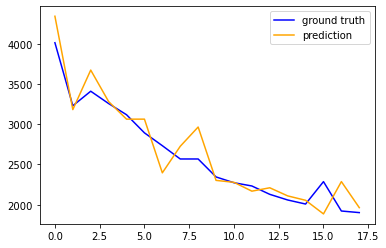

In [16]:
truth = raw_value[-test_size:].to_list()
plt.plot(truth, color = 'blue', label = "ground truth")
plt.plot(forecasts, color = 'orange', label = "prediction")
plt.legend()
plt.savefig("comb_demo.png", dpi=600)

In [17]:
model.weights

[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(7, 4) dtype=float32, numpy=
 array([[-0.8422186 ,  0.696076  , -0.7958633 , -0.5177796 ],
        [-0.11659252,  0.43581825,  0.7643814 ,  0.1933292 ],
        [-0.37530604,  0.07526505, -0.27054524,  0.18257754],
        [-0.7409403 ,  0.17471737,  0.31557715, -0.87158626],
        [-0.29592425,  0.00608528, -0.4778689 , -0.19148307],
        [-1.0941647 ,  0.1695162 , -0.33937803, -0.87413174],
        [ 0.80717057, -0.47554561,  0.2325327 , -0.02598247]],
       dtype=float32)>,
 <tf.Variable 'lstm/lstm_cell/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
 array([[-0.19530737,  0.8885204 ,  0.14280264, -0.38986364]],
       dtype=float32)>,
 <tf.Variable 'lstm/lstm_cell/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.14534834,  1.        , -0.07763673,  0.15898521], dtype=float32)>,
 <tf.Variable 'linear/linear_layer_kernel:0' shape=(7, 1) dtype=float32, numpy=
 array([[-0.5486296 ],
        [ 0.40754864],
        [ 0.49656695]

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 7)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 1)            36          input_2[0][0]                    
__________________________________________________________________________________________________
linear (Linear)                 (None, 1)            8           input_1[0][0]                    
______________________________________________________________________________________________

# Perform on All countries, All Trials

In [19]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
diff = 1 # order of difference
train_size = 63  # train set size
test_size = 18 # test set size

n_step = 7  # step size

n_batch = 1
nb_epoch = 100
n_neurons = 1

In [20]:
# holder for rmse:
RMSE = []
MAE = []
MAPE = []

for i in range(len(countries)):
    country = countries[i]
    s = extract(df1, country)
    temp_RMSE = []
    temp_MAE = []
    temp_MAPE = []
    for j in range(0, len(df1)-(train_size+test_size+n_lag)+1, n_step):
        # prepare data
        raw_value = s[j:j+(train_size+test_size+n_lag)]
        
        # for hybrid weighted
        scaler, train, test = prepare_data(raw_value, diff, train_size, test_size, n_lag, n_seq)
        model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
        forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
        rmse_comb, mae_comb, mape_comb = evaluate_forecasts(raw_value[-test_size:], forecasts)
        
        temp_RMSE.append(rmse_comb)
        temp_MAE.append(mae_comb)
        temp_MAPE.append(mape_comb)
    
    RMSE.append(temp_RMSE)
    MAE.append(temp_MAE)
    MAPE.append(temp_MAPE)
    print(country)

Japan
Canada
Brazil
Argentina
Singapore
Italy
The United Kingdom


## save the results

In [21]:
for i in range(len(countries)):
    country = countries[i]
    temp_RMSE = RMSE[i]
    temp_MAE = MAE[i]
    temp_MAPE = MAPE[i]
    
    curr = {"rmse": temp_RMSE, "mae": temp_MAE, "mape": temp_MAPE}
    curr = pd.DataFrame(curr)
    curr.to_csv(country+"_alpha_hybrid.csv", index = False)

In [22]:
curr

,rmse,mae,mape
0,72.407679,58.575179,1.288413
1,73.158148,60.473313,1.450300
2,84.629198,67.548740,1.886885
3,95.330463,78.920212,2.662855
4,58.827591,47.076530,1.892605
...,...,...,...
118,266.636503,209.833829,1.660282
119,135.906642,93.702674,0.981298
120,41.282597,33.666318,0.528561
121,43.725701,36.806475,0.707779


## show averages

In [23]:
ave_rmse = []
ave_mae = []
ave_mape = []
for i in range(len(countries)):
    country = countries[i]
    temp_RMSE = RMSE[i]
    temp_MAE = MAE[i]
    temp_MAPE = MAPE[i]
    
    ave_rmse.append(np.mean(temp_RMSE))
    ave_mae.append(np.mean(temp_MAE))
    ave_mape.append(np.mean(temp_MAPE))

hybrid_alpha = {"country": countries, "rmse": ave_rmse, "mae": ave_mae, "mape": ave_mape}
hybrid_alpha = pd.DataFrame(hybrid_alpha)
hybrid_alpha

,country,rmse,mae,mape
0,Japan,941.442876,705.203398,5.566391
1,Canada,189.206361,137.982984,3.274779
2,Brazil,2165.563673,1627.635650,4.512235
3,Argentina,589.923236,439.017536,4.644018
4,Singapore,121.369618,93.232633,7.212775
5,Italy,951.623689,739.560713,3.119144
6,The United Kingdom,685.763743,529.933445,1.813707


In [24]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

# alternative:
# scipy.stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

In [29]:
# import data
meanCI_rmse = []
meanCI_mae = []
meanCI_mape = []
for country in countries:
    df = pd.read_csv(country + '_alpha_hybrid.csv', index_col = False)
    df.reset_index(drop=True, inplace=True)
    rmse = df[["rmse"]]
    mean_rmse, h_rmse = mean_confidence_interval(rmse, confidence=0.95)
    meanCI_rmse.append([mean_rmse, h_rmse])
    
    mae = df[["mae"]]
    mean_mae, h_mae = mean_confidence_interval(mae, confidence=0.95)
    meanCI_mae.append([mean_mae, h_mae])
    
    mape = df[["mape"]]
    mean_mape, h_mape = mean_confidence_interval(mape, confidence=0.95)
    meanCI_mape.append([mean_mape, h_mape])

In [30]:
meanCI_rmse

[[941.442875911626, array([374.5468148])],
 [189.20636127682855, array([63.83381149])],
 [2165.563672519561, array([366.06258832])],
 [589.9232357367111, array([211.61482358])],
 [121.36961762214597, array([34.17057046])],
 [951.6236890589397, array([331.23923375])],
 [685.7637432655756, array([231.84528741])]]

In [31]:
meanCI_mae

[[705.2033983726532, array([268.6952909])],
 [137.98298426179016, array([44.83487122])],
 [1627.6356501581595, array([278.11167325])],
 [439.01753622282394, array([168.70576014])],
 [93.23263303261744, array([27.19509433])],
 [739.5607126760699, array([262.16927952])],
 [529.9334452158627, array([178.91038219])]]

In [32]:
meanCI_mape

[[5.566390535464389, array([1.35871203])],
 [3.2747788763951897, array([0.60852136])],
 [4.512235226037097, array([0.51977929])],
 [4.64401805802628, array([0.83334576])],
 [7.2127747317975786, array([1.26270574])],
 [3.1191441105288513, array([0.49232808])],
 [1.8137069423119088, array([0.18433166])]]